## General Adversarial Networks

Generative Adversarial Networks (GANs) were originally proposed in the 2014 [paper of the same name](https://arxiv.org/abs/1406.2661).  The idea is to have two distinct networks, the generator and the discriminator.  The generator network takes random noise as input and produces an image.  The discriminator network is trained on these sythetically generate images as well as real images, it is then given the task of distinguishing between fake and real images.  GANs give impressive results, but training them can be tricky.  Training GANs is sometimes more of an art than a science, with instable training and mode collapse both happening often.  See [here](https://github.com/soumith/ganhacks) for a good list of tips on how to effective train GANs.

In [13]:
import torch
import cv2
import numpy as np
import random
from skimage import transform
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import MNIST

## Model

For the architecture we will use DCGAN.  The code is taken from the [PyTorch documentation](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) and is a good place to start with GANs.  The [DCGAN paper](https://arxiv.org/abs/1511.06434) also gives some good recomendations on how GAN architectures should be designed.

In [14]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
        )

        self.main2 = nn.Sequential(
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )

        self.main3 = nn.Sequential(
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )
        self.main4 = nn.Sequential(
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.main1(input)
        x = self.main2(x)
        x = self.main3(x)
        x = self.main4(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the number of parameters for the generator
print("Num params (generator): ", sum(p.numel() for p in netG.parameters()))

Num params (generator):  3444480


In [17]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.main3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.main4 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main1(input)
        x = self.main2(x)
        x = self.main3(x)
        x = self.main4(x)
        return x

  
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the number of parameters for the discriminator
print("Num params (discriminator): ", sum(p.numel() for p in netD.parameters()))

Num params (discriminator):  659456


## Data

Download and plot some examples from the training data. We will use the MNIST dataset for the sake of simplicity.

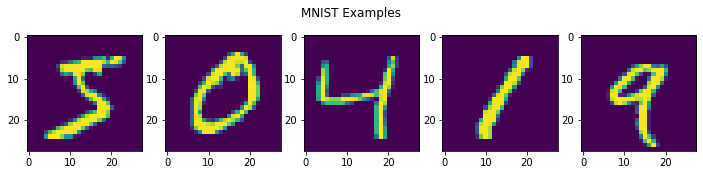

In [18]:
# Are we using the CPU or the GPU?
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transforms to be applied to all images in the dataset
tf = transforms.Compose(
    [transforms.ToTensor()]
)

# Download/setup the MNIST dataset
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Examples')
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[1].imshow(dataset[1][0][0,:,:].numpy())
ax[2].imshow(dataset[2][0][0,:,:].numpy())
ax[3].imshow(dataset[3][0][0,:,:].numpy())
ax[4].imshow(dataset[4][0][0,:,:].numpy())


## Loss Function

GANs are optimised by playing a minimax game with the value function $V$

$$ \underset{G}{\min} ~ \underset{D}{\max} ~ V(D,G) = \mathbb{E}_{x \sim p_{data}(x)}[\text{log}(D(x))] + {\mathbb{E}_{z \sim p_{z}(z)}}[\text{log}(1-D(G(z)))]$$

where

$ ~~~~~~~~~~~~ D=$ discriminator network

$ ~~~~~~~~~~~~ G = $ generator network

$ ~~~~~~~~~~~~ z = $ random vector

$ ~~~~~~~~~~~~ x=$ real image

The first term represents the discriminators predictions on real data and the second term represents the discriminators predictions on the fake data.  We want our discriminator network $D$ to predict a $1$ when it is given a real image and $0$ when given a fake image.  If $D$ acheives both of these aims, then the loss function will have been maximised. The generator on the other hand wants to fool the discriminator. The generator wants $D$ to incorrectly predict $1$ when it is given fake data.  This sets up the adversarial minimax game.

We could implement this loss function directly, but lots of people use binary cross entropy loss because it is equivalent

$$L_{BCE} = -\sum_{i=1}^N{y_i \text{log}(D(x)) + (1-y_i) \text{log}(1-D(G(z)))} $$

where $y$ is the ground truth and we have $N$ data points. So when $y=0$ the first term is ignored, and when $y=1$ the second term is ignored.  This makes intuative sense because the first term optimises on real data and the seond term on fake data.  We can then add loss for fake value (when $y=0$) and loss for real values (when $y=1$) to obtain our original loss function above (more or less).


In [19]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

Training GANs happens in a two stage process which is repeated
1. Update the weights of the discriminator.  This is done by ascending its stocastic gradient:
$$\nabla_{\theta_d} \frac{1}{m}\sum_{i=1}^{m}\text{log}(D(x))+\text{log}(1-D(G(z)))$$

2. Update the weights of the generator.  We can ignore the first term of the loss because the generator is not included.  This is done by descending its stocastic gradient:
$$\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^{m}\text{log}(1-D(G(z)))$$

Step 1 can be done repeatedly, however, in this implementation it is just run once.

In [20]:
# Hyperparameters
num_epochs = 100

# Set up dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Training Loop
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu.float()).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.clone().detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


[0/100][0/469]	Loss_D: 1.1623	Loss_G: 1.5797	D(x): 0.6155	D(G(z)): 0.4644 / 0.2281
[0/100][200/469]	Loss_D: 0.0828	Loss_G: 3.2073	D(x): 0.9428	D(G(z)): 0.0214 / 0.0510
[0/100][400/469]	Loss_D: 0.1790	Loss_G: 3.0430	D(x): 0.9355	D(G(z)): 0.1018 / 0.0576
[1/100][0/469]	Loss_D: 0.0617	Loss_G: 4.1210	D(x): 0.9669	D(G(z)): 0.0265 / 0.0220
[1/100][200/469]	Loss_D: 0.0509	Loss_G: 4.5549	D(x): 0.9808	D(G(z)): 0.0302 / 0.0158
[1/100][400/469]	Loss_D: 0.0347	Loss_G: 4.6918	D(x): 0.9853	D(G(z)): 0.0192 / 0.0133
[2/100][0/469]	Loss_D: 0.0320	Loss_G: 4.8247	D(x): 0.9822	D(G(z)): 0.0135 / 0.0131
[2/100][200/469]	Loss_D: 7.1545	Loss_G: 0.1388	D(x): 0.0059	D(G(z)): 0.0034 / 0.9114
[2/100][400/469]	Loss_D: 0.1938	Loss_G: 3.2588	D(x): 0.9593	D(G(z)): 0.1348 / 0.0482
[3/100][0/469]	Loss_D: 0.0567	Loss_G: 4.1523	D(x): 0.9684	D(G(z)): 0.0230 / 0.0211
[3/100][200/469]	Loss_D: 0.0487	Loss_G: 4.7200	D(x): 0.9830	D(G(z)): 0.0303 / 0.0124
[3/100][400/469]	Loss_D: 0.3070	Loss_G: 2.4662	D(x): 0.8593	D(G(z)): 0.13

## Sampling

We do not need the discriminator to generator samples, just the generator.  Here we generate and display 64 MNIST images.

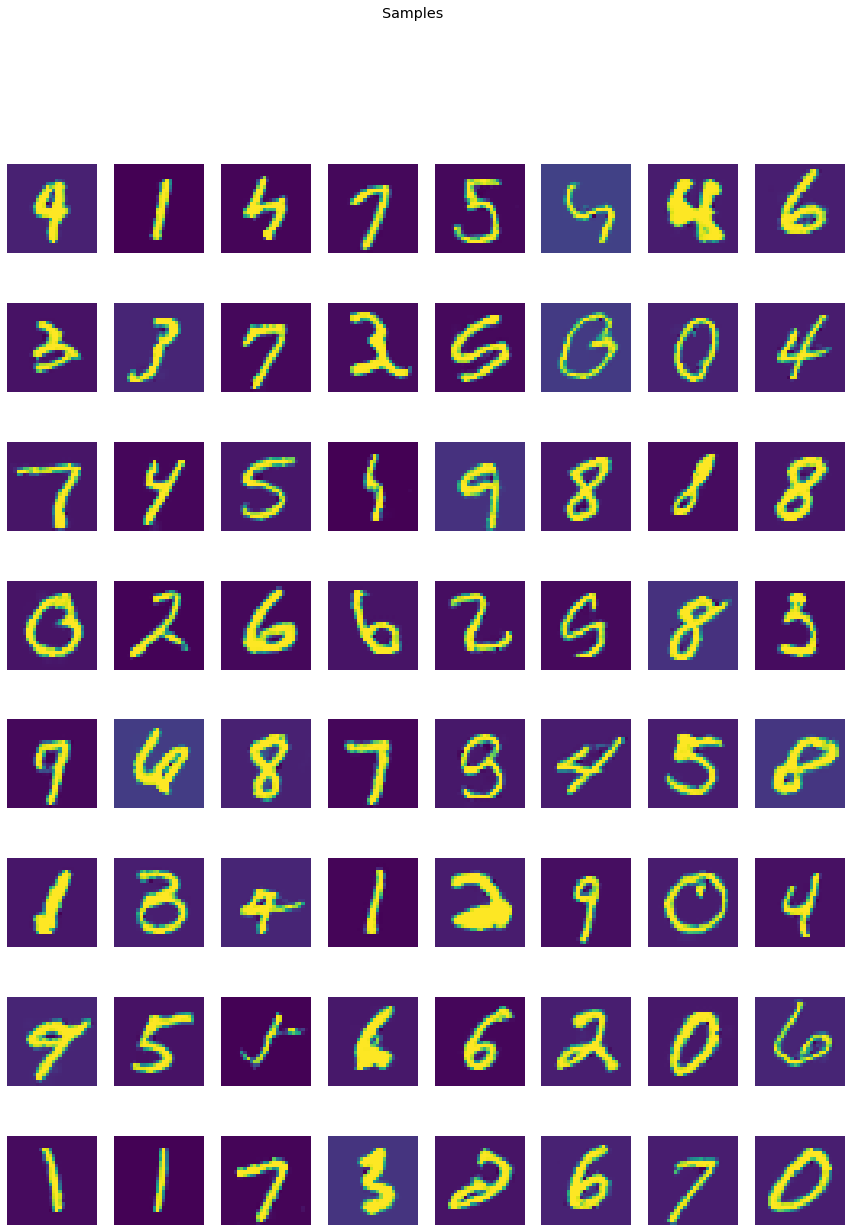

In [21]:
# Generate batch of latent vectors
batch_size = 64
noise = torch.randn(batch_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)

# Initalize plots 
fig, axs = plt.subplots(8, 8, figsize=(15,20))
fig.suptitle("Samples", fontsize="x-large")

for i in range(batch_size):
  fake_img = fake[i,0,:,:]
  fake_img = fake_img.cpu().detach().numpy()

  axs[int(i / 8), int(i % 8)].imshow(fake_img)
  axs[int(i / 8), int(i % 8)].axis('off')
